In [1]:
#普通模块
import cudf
import h5py
import argparse
import numba as nb
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import os.path as osp
import scipy.sparse as sp
from IPython.display import Image

#sklearn 模块
from sklearn import neighbors
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, adjusted_rand_score,
                             calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#pytorch模块
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam

#GCL模块
import GCL.losses as L
import GCL.augmentors as A
from GCL.models import DualBranchContrast,SingleBranchContrast

#pyg模块
from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn.inits import uniform
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_undirected
from torch_geometric.nn import GCNConv,GCN2Conv,GATv2Conv,GCN,GATConv

#自定义模块
#import contrastive_loss
import evaluation
from utils import filter_data,input_data, cal_weights_via_CAN, normalize, draw_fig, distance

In [2]:
parser = argparse.ArgumentParser(description='Grace')
parser.add_argument('--dataset',type=str,default='../../data/QS_Lung.h5ad')
parser.add_argument('--graph',type=str,default='knn')
parser.add_argument('--filter',type=str,default='nofilter')
args = parser.parse_args([])

In [3]:
args.filter

'nofilter'

In [4]:
if args.filter == 'filter':
    adata = sc.read_h5ad(args.dataset)
    true_label = np.array(adata.obs.cell_label)
    label_number = np.unique(true_label).max() - np.unique(true_label).min() + 1
    adata = filter_data(adata.X, highly_genes=3000)
    
    input_size = adata.X.shape[1]
    
    print('label_number:',label_number)
    print('adata_shape:',adata.X.shape)

if args.filter == 'nofilter':
    adata = input_data(args.dataset)
    true_label = np.array(adata.obs.cell_label)
    input_size = adata.X.shape[1]

label_number: 11
Successfully preprocessed 1676 cells and 18162 genes.


In [5]:
input_size

18162

In [6]:
'''data_mat = h5py.File(args.dataset)
X = np.array(data_mat['X'])
true_label = np.array(data_mat['Y'])


label_number = np.unique(true_label)
adata = filter_data(X, highly_genes=3000)
input_size = adata.X.shape[1]

print('label_number:',label_number.max())
print('adata_shape:',adata.X.shape)'''

"data_mat = h5py.File(args.dataset)\nX = np.array(data_mat['X'])\ntrue_label = np.array(data_mat['Y'])\n\n\nlabel_number = np.unique(true_label)\nadata = filter_data(X, highly_genes=3000)\ninput_size = adata.X.shape[1]\n\nprint('label_number:',label_number.max())\nprint('adata_shape:',adata.X.shape)"

In [7]:
if args.graph == 'knn':
    KNN_graph = neighbors.kneighbors_graph(adata.X, n_neighbors=10, mode = 'connectivity', n_jobs=30)
    KNN_g = np.array(np.nonzero(KNN_graph.todense()))
    source = np.array(KNN_g[0])
    target = np.array(KNN_g[1])
    edge_index = torch.tensor([source,target], dtype=torch.long)
    edge_index = to_undirected(edge_index)
    graph = Data(x=torch.tensor(adata.X),edge_index=edge_index)
    norm = T.GCNNorm()
    graph = norm(graph)
    
if args.graph == 'CAN':
    adj, raw_weights = cal_weights_via_CAN(torch.tensor(adata.X.T), num_neighbors=10)
    adj = adj.cpu().detach().numpy()
    adj = normalize(adj)
    adj = sp.coo_matrix(adj)
    
    indices=np.vstack((adj.row,adj.col))
    edge_index = torch.LongTensor(indices)
    edge_index = to_undirected(edge_index)
    values=torch.FloatTensor(adj.data)
    
    graph = Data(x=torch.tensor(adata.X),edge_index=edge_index)
    adj, raw_weights = cal_weights_via_CAN(torch.tensor(adata.X.T), num_neighbors=5)

/tmp/ipykernel_189464/988050335.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  edge_index = torch.tensor([source,target], dtype=torch.long)


In [8]:
class GConv(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, activation, num_layers):
        super(GConv, self).__init__()
        self.activation = activation()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GATConv(input_dim, hidden_dim,dropout=0.8))
        for _ in range(num_layers - 1):
            self.layers.append(GCNConv(hidden_dim, hidden_dim))

    def forward(self, x, edge_index, edge_weight):
        z = x.float()
        for i, conv in enumerate(self.layers):
            z = conv(z, edge_index, edge_weight)
            z = self.activation(z)
        return z

In [9]:
class Encoder(torch.nn.Module):
    def __init__(self, encoder, augmentor, hidden_dim, proj_dim):
        super(Encoder, self).__init__()
        self.encoder = encoder
        self.augmentor = augmentor

        self.fc1 = torch.nn.Linear(hidden_dim, proj_dim)
        self.fc2 = torch.nn.Linear(proj_dim, hidden_dim)

    def forward(self, x, edge_index, edge_weight=None):
        aug1, aug2 = self.augmentor
        x1, edge_index1, edge_weight1 = aug1(x, edge_index, edge_weight)
        x2, edge_index2, edge_weight2 = aug2(x, edge_index, edge_weight)
        z = self.encoder(x, edge_index, edge_weight)
        z1 = self.encoder(x1, edge_index1, edge_weight1)
        z2 = self.encoder(x2, edge_index2, edge_weight2)
        h,h1,h2 = [self.project(x) for x in [z,z1,z2]] 
        return h,h1,h2
    
    def project(self, z: torch.Tensor) -> torch.Tensor:
        z = F.elu(self.fc1(z))
        return self.fc2(z)

In [10]:
def train(encoder_model, contrast_model, data, optimizer):
    encoder_model.train()
    optimizer.zero_grad()
    h, h1, h2 = encoder_model(data.x, data.edge_index, data.edge_attr)
    loss = contrast_model(h1, h2)
    loss.backward()
    optimizer.step()
    return loss.item()

In [11]:
@torch.no_grad()
def test(encoder_model, data):
    encoder_model.eval()
    h, h1, h2 = encoder_model(data.x, data.edge_index)
    return h

In [12]:
def main():
    seed = 21
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
    device = torch.device('cuda:0')
    data = graph.to(device)
    
    kmeans = KMeans(n_clusters=11, init="k-means++", random_state=5)
    
    def run_leiden(data):
        adata = sc.AnnData(data)
        sc.pp.neighbors(adata, use_rep='X', n_neighbors = 30, n_pcs = 40)
        sc.tl.leiden(adata)
        pred = adata.obs['leiden'].to_list()
        pred = [int(x) for x in pred]
        return pred

    aug1 = A.Compose([A.EdgeRemoving(pe=0.7), A.FeatureMasking(pf=0.7)])
    aug2 = A.Compose([A.EdgeRemoving(pe=0.7), A.FeatureMasking(pf=0.7)])

    gconv = GConv(input_dim=input_size, hidden_dim=256, activation=torch.nn.GELU, num_layers=2).to(device)
    encoder_model = Encoder(encoder=gconv, augmentor=(aug1, aug2), hidden_dim=256, proj_dim=128).to(device)

    contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=0.05), mode='L2L', intraview_negs=True).to(device)
    
    optimizer = AdamW(encoder_model.parameters(), lr=3e-4)
    
    ari_klist = []
    ari_llist = []
    losslist = []
    with tqdm(total=5000, desc='(T)') as pbar:
        for epoch in range(1, 5001):
            loss = train(encoder_model, contrast_model, data, optimizer)
            pbar.set_postfix({'loss': loss})
            pbar.update()
            
            losslist.append(loss)
            
            '''z = test(encoder_model, data).detach().cpu()
            
            if epoch % 100 == 0:
                kmeans_pred = kmeans.fit_predict(z)
                ari_k = round(adjusted_rand_score(true_label, kmeans_pred), 4)
                ari_klist.append(ari_k)'''
            
    z = test(encoder_model, data).detach().cpu()
    print(z.shape)
    
    kmeans_pred = kmeans.fit_predict(z)
    ari_k = round(adjusted_rand_score(true_label, kmeans_pred), 4)
    nmi_k = round(normalized_mutual_info_score(true_label, kmeans_pred), 4)
    ari_klist.append(ari_k)
    
    '''
    leiden_pred = run_leiden(np.array(z))
    ari_l = round(adjusted_rand_score(true_label, leiden_pred), 4)
    ari_llist.append(ari_l)
                
    '''
        
 
    return ari_klist

In [39]:
ari_klist = main()
print(ari_klist)

Encoder(
  (encoder): GConv(
    (activation): GELU()
    (layers): ModuleList(
      (0): GATConv(18162, 128, heads=1)
      (1): GCNConv(128, 128)
    )
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
)


(T): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:27<00:00, 57.17it/s, loss=5.08]


torch.Size([1676, 128])
[0.4986]


range(1, 5001)


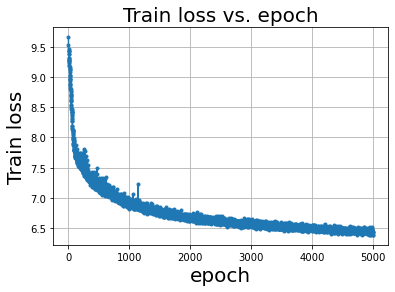

In [18]:
draw_fig(losslist,'loss',5000)

In [ ]:
ari_k = []
for i in range(5):
    ari_klist = main()
    print(ari_klist)
    ari_k.append(ari_klist[0])
ari = sum(ari_k)/len(ari_k)
print(ari)

(T):  16%|████████████████████▌                                                                                                        | 820/5000 [00:22<01:18, 53.57it/s, loss=5.53]

In [17]:
ari_k

[0.574, 0.528, 0.5559, 0.5776, 0.5767]

In [ ]:

Young: 0.5624 3000epochs 3000高变基因 3
mouse_ES_cell: 0.5715 3000epochs 3000高变基因 4
mouse_bladder.h5ad: 0.5361 1797高变基因 2
worm_neuron.h5ad: 0.2737  1328高变基因 3
QS_Trachea.h5ad: 0.563

10X_PBMC.h5ad: 0.6277799999999999 1291高变基因
Romanov.h5ad: 0.521 3000高变基因
QS_Diaphragm.h5ad: 0.8492200000000001 3000高变基因
QS_Limb_Muscle.h5ad: 0.9024599999999999 3000高变基因
QS_Lung.h5ad: 0.50148 3000高变基因

In [ ]:
10X_PBMC.h5ad:0.66


In [62]:
#调参
d={}
for x in np.arange(0.1,0.9,0.1):
    ari_klist1, ari_llist1 = main(x)
    ari_klist2, ari_llist1 = main(x)
    ari_klist3, ari_llist1 = main(x)
    ari_klist4, ari_llist1 = main(x)
    ari_klist5, ari_llist1 = main(x)
    ari_klist = (ari_klist1[0] + ari_klist2[0] + ari_klist3[0] + ari_klist4[0] + ari_klist5[0]) / 5
    
    d["ari{0}".format(x)]= ari_klist

(T): 100%|██████████████████████████████████████| 3000/3000 [01:39<00:00, 30.27it/s, loss=6.04]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.36it/s, loss=5.97]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.45it/s, loss=5.93]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:39<00:00, 30.30it/s, loss=5.96]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:37<00:00, 30.66it/s, loss=5.96]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:39<00:00, 30.25it/s, loss=6.17]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:37<00:00, 30.90it/s, loss=6.17]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:37<00:00, 30.65it/s, loss=6.17]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.55it/s, loss=6.15]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:37<00:00, 30.63it/s, loss=6.14]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.59it/s, loss=6.27]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.59it/s, loss=6.27]


torch.Size([4271, 256])


(T): 100%|███████████████████████████████████████| 3000/3000 [01:39<00:00, 30.14it/s, loss=6.3]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.35it/s, loss=6.37]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:39<00:00, 30.24it/s, loss=6.32]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:39<00:00, 30.30it/s, loss=6.47]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.41it/s, loss=6.47]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.34it/s, loss=6.38]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.42it/s, loss=6.41]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.37it/s, loss=6.47]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.34it/s, loss=6.51]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.32it/s, loss=6.51]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:39<00:00, 30.29it/s, loss=6.62]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.32it/s, loss=6.69]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:39<00:00, 30.05it/s, loss=6.66]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:37<00:00, 30.67it/s, loss=6.73]


torch.Size([4271, 256])


(T): 100%|███████████████████████████████████████| 3000/3000 [01:38<00:00, 30.31it/s, loss=6.8]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.61it/s, loss=6.77]


torch.Size([4271, 256])


(T): 100%|███████████████████████████████████████| 3000/3000 [01:38<00:00, 30.49it/s, loss=6.8]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.58it/s, loss=6.75]


torch.Size([4271, 256])


(T): 100%|███████████████████████████████████████| 3000/3000 [01:38<00:00, 30.42it/s, loss=6.9]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.53it/s, loss=6.91]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.54it/s, loss=6.87]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:37<00:00, 30.62it/s, loss=6.93]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:37<00:00, 30.63it/s, loss=6.96]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:39<00:00, 30.26it/s, loss=7.14]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.47it/s, loss=7.12]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.49it/s, loss=7.12]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.48it/s, loss=7.08]


torch.Size([4271, 256])


(T): 100%|██████████████████████████████████████| 3000/3000 [01:38<00:00, 30.54it/s, loss=7.22]


torch.Size([4271, 256])
